# Working with Geopandas

![](images/python_foundation/geopandas.png)


GeoPandas extends the Pandas library to enable spatial operations. It provides new data types such as **GeoDataFrame** and **GeoSeries** which are subclasses of Pandas **DataFrame** and **Series** and enables efficient vector data processing in Python.


GeoPandas make use of many other widely used spatial libraries - but it provides an interface similar to Pandas that make it intuitive to use it with spatial analysis. GeoPandas is built on top of the following libraries that allow it to be spatially aware.

- [Shapely](https://shapely.readthedocs.io/en/latest/manual.html) for geometric operations (i.e. buffer, intersections etc.)
- [PyProj](https://pyproj4.github.io/pyproj/stable/index.html) for working with projections
- [Fiona](https://pypi.org/project/Fiona/) for file input and output, which itself is based on the widely used [GDAL/OGR](https://gdal.org/) library

We will carry out a geoprocessing task that shows various features of this library and show how to do geo data processing in Python. The task is to take a roads data layer from OpenStreetMap and compute the total length of National Highways for each district in a state. The problem is described in detail in my [Advanced QGIS](https://courses.spatialthoughts.com/advanced-qgis.html#exercise-find-the-length-of-national-highways-in-a-state) course and show the steps needed to perform this analysis in QGIS. We will replicate this example in Python.

![](https://github.com/spatialthoughts/courses/blob/master/code/python_foundation/images/python_foundation/karnataka.png?raw=1)


By convention, `geopandas` is commonly imported as `gpd`

In [1]:
import geopandas as gpd

## Reading Spatial Data

In [2]:
import os
data_pkg_path = 'data'
filename = 'karnataka.gpkg'
path = os.path.join(data_pkg_path, filename)

GeoPandas has a `read_file()` method that is able to open a wide variety of vector datasets, including zip files. Here we will open the GeoPackage `karnataka.gpkg` and read a layer called `karnataka_major_roads`. The result of the read method is a **GeoDataFrame**. 

In [3]:
roads_gdf = gpd.read_file(path, layer='karnataka_major_roads')
print(roads_gdf.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 44606 entries, 0 to 44605
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   osm_id    44606 non-null  object  
 1   code      44606 non-null  int64   
 2   fclass    44606 non-null  object  
 3   name      7018 non-null   object  
 4   ref       7702 non-null   object  
 5   oneway    44606 non-null  object  
 6   maxspeed  44606 non-null  int64   
 7   layer     44606 non-null  int64   
 8   bridge    44606 non-null  object  
 9   tunnel    44606 non-null  object  
 10  geometry  44606 non-null  geometry
dtypes: geometry(1), int64(3), object(7)
memory usage: 3.7+ MB
None


A GeoDataFrame contains a special column called *geometry*. All spatial operations on the GeoDataFrame are applied to the geomety column. The geometry column can be accessed using the `geometry` attribute.

In [4]:
print(roads_gdf.geometry)

0        MULTILINESTRING ((77.59928 12.97672, 77.59950 ...
1        MULTILINESTRING ((76.65944 12.31809, 76.65904 ...
2        MULTILINESTRING ((76.65906 12.31389, 76.65912 ...
3        MULTILINESTRING ((76.65600 12.30895, 76.65646 ...
4        MULTILINESTRING ((76.65615 12.30989, 76.65600 ...
                               ...                        
44601    MULTILINESTRING ((77.60806 12.97517, 77.60797 ...
44602    MULTILINESTRING ((77.60798 12.97519, 77.60806 ...
44603    MULTILINESTRING ((77.57115 13.00849, 77.57156 ...
44604    MULTILINESTRING ((77.70140 12.95693, 77.70164 ...
44605    MULTILINESTRING ((77.61040 12.97360, 77.61052 ...
Name: geometry, Length: 44606, dtype: geometry


## Filtering Data

One can use the standard Pandas filtering methods to select a subset of the GeoDataFrame. In addition, GeoPandas also provide way to subset the data based on a bounding box with the [`cx[]` indexer](https://geopandas.readthedocs.io/en/latest/indexing.html).

For our analysis, we need to apply a filter to extract only the road segments where the `ref` attribute starts with **'NH'** - indicating a national highway. We can apply boolean filtering using Panda's `str.match()` method with a regular expression.

In [5]:
filtered = roads_gdf[roads_gdf['ref'].str.match('^NH') == True]
print(filtered.head())

      osm_id  code fclass                        name    ref oneway  maxspeed  \
17   8684837  5112  trunk  Bengaluru - Mangaluru Road  NH373      F         0   
26   9951034  5112  trunk                         NaN  NH948      B        50   
54  22838314  5112  trunk   Solapur-Mangalore Highway  NH169      B         0   
55  22838318  5112  trunk                         NaN   NH66      B         0   
56  22838318  5112  trunk                         NaN   NH66      B         0   

    layer bridge tunnel                                           geometry  
17      0      F      F  MULTILINESTRING ((76.10024 13.00326, 76.09950 ...  
26      0      F      F  MULTILINESTRING ((77.16472 12.24774, 77.16416 ...  
54      0      F      F  MULTILINESTRING ((74.86387 12.88387, 74.86419 ...  
55      0      F      F  MULTILINESTRING ((74.78756 13.09142, 74.78744 ...  
56      0      F      F  MULTILINESTRING ((74.78767 13.09723, 74.78767 ...  


## Working with Projections

Dealing with projetions is a key aspect of working with spatial data. GeoPandas uses the `pyproj` library to assign and manage projections. Each GeoDataFrame as a `crs` attribute that contains the projection info. Our source dataset is in EPSG:4326 WGS84 CRS.

In [6]:
print(filtered.crs)

EPSG:4326


Since our task is to compute line lengths, we need to use a Projected CRS. We can use the `to_crs()` method to reproject the GeoDataFrame.

In [7]:
roads_reprojected = filtered.to_crs('EPSG:32643')
print(roads_reprojected.crs)

EPSG:32643


Now that the layer has been reprojected, we can calculate the length of each geometry using the `length` attribute. The result would be in meters. We can add the line lengths in a new column named `length`.

In [8]:
roads_reprojected['length'] = roads_reprojected['geometry'].length

We can apply statistical operations on a DataFrame columns. Here we can compute the total length of national highways in the state by calling the `sum()` method.

In [9]:
total_length = roads_reprojected['length'].sum()
print('Total length of national highways in the state is {} KM'.format(total_length/1000))

Total length of national highways in the state is 8616.166058402969 KM


Now plot the data.

<Axes: >

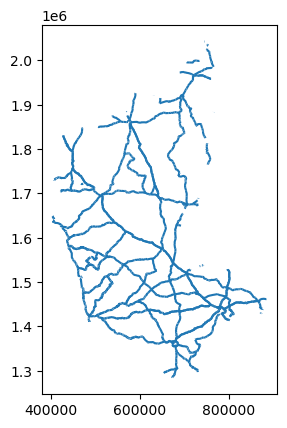

In [10]:
roads_reprojected.plot()

## Performing Spatial joins

There are two ways to combine datasets in geopandas – table joins and spatial joins. For our task, we need information about which district each road segments belongs to. This can be achived using another spatial layer for the districts and doing a spatial join to transfer the attributes of the district layer to the matching road segment.

The `karnataka.gpkg` contains a layer called `karnataka_districts` with the district boundaries and names.

In [11]:
districts_gdf = gpd.read_file(path, layer='karnataka_districts')
print(districts_gdf.head())

          DISTRICT      ST_NM  ST_CEN_CD  DT_CEN_CD  censuscode  \
0         Bagalkot  Karnataka         29          2         556   
1  Bangalore Rural  Karnataka         29         29         583   
2        Bangalore  Karnataka         29         18         572   
3          Belgaum  Karnataka         29          1         555   
4          Bellary  Karnataka         29         11         565   

                                            geometry  
0  MULTIPOLYGON (((76.24100 16.16531, 76.23538 16...  
1  MULTIPOLYGON (((77.38701 13.50002, 77.40099 13...  
2  MULTIPOLYGON (((77.83549 12.86809, 77.83213 12...  
3  MULTIPOLYGON (((75.02647 16.93264, 75.02827 16...  
4  MULTIPOLYGON (((77.15757 15.13706, 77.15887 15...  


Before joining this layer to the roads, we must reproject it to match the CRS of the roads layer.

In [12]:
districts_reprojected = districts_gdf.to_crs('EPSG:32643')

A spatial join is performed using the `sjoin()` method. It takes 2 core arguments.

- `predicate`: The spatial predicate to decide which objects to join. Options are *intersects*, *within* and *contains*.
- `how`: The type of join to perform. Options are *left*, *right* and *inner*.

For our task, we can do a *left* join and add attributes of the district that *intersect* the road.

*Note This does not add geometry to roads_reprojected, rather geometry for roads gains attributes from districts.

In [14]:
joined = gpd.sjoin(roads_reprojected, districts_reprojected, how='left', predicate='intersects')
print(joined.head())

      osm_id  code fclass                        name    ref oneway  maxspeed  \
17   8684837  5112  trunk  Bengaluru - Mangaluru Road  NH373      F         0   
26   9951034  5112  trunk                         NaN  NH948      B        50   
54  22838314  5112  trunk   Solapur-Mangalore Highway  NH169      B         0   
55  22838318  5112  trunk                         NaN   NH66      B         0   
55  22838318  5112  trunk                         NaN   NH66      B         0   

    layer bridge tunnel                                           geometry  \
17      0      F      F  MULTILINESTRING ((619317.005 1437753.696, 6192...   
26      0      F      F  MULTILINESTRING ((735483.761 1354892.067, 7354...   
54      0      F      F  MULTILINESTRING ((485231.162 1424297.721, 4852...   
55      0      F      F  MULTILINESTRING ((476971.413 1447255.675, 4769...   
55      0      F      F  MULTILINESTRING ((476971.413 1447255.675, 4769...   

          length  index_right          DISTR

## Group Statistics

The resulting geodataframe now has the matching column from the intersecting district feature. We can now sum the length of the roads and group them by districts. This type of *Group Statistics* is performed using Panda's `group_by()` method.

In [26]:
results = joined.groupby('DISTRICT')['length'].sum()/1000
print(results)

DISTRICT
Bagalkot            258.449475
Bangalore           314.170539
Bangalore Rural     319.965959
Belgaum             528.922541
Bellary             304.789522
Bidar               247.348300
Bijapur             424.197281
Chamrajnagar        217.737255
Chikkaballapura     211.957819
Chikmagalur         334.423573
Chitradurga         531.932443
Dakshina Kannada    316.339566
Davanagere          177.877407
Dharwad             314.978752
Gadag               111.548768
Gulbarga            294.551578
Hassan              436.231356
Haveri              306.582730
Kodagu               63.806864
Kolar               221.598406
Koppal              288.358711
Mandya              337.555904
Mysore              361.510005
Raichur             167.746669
Ramanagara          199.426362
Shimoga             479.140995
Tumkur              613.177564
Udupi               277.331577
Uttara Kannada      424.184040
Yadgir              144.858328
Name: length, dtype: float64


The result of the `group_by()` method is a Pandas *Series*. It can be saved to a CSV file using the `to_csv()` method.

In [18]:
output_filename = 'national_highways_by_districts.csv'
output_dir = 'output'
output_path = os.path.join(output_dir, output_filename)
results = results.round()
results.to_csv(output_path)
print('Successfully written output file at {}'.format(output_path))

Successfully written output file at output\national_highways_by_districts.csv


Compare the columns in roads, districts, and joined.

In [25]:
print('roads:',end=' ')
print([x for x in roads_reprojected.columns])
print()
print('districts:',end=' ')
print([x for x in districts_reprojected.columns])
print()
print('joined:',end=' ')
print([x for x in joined])
print()

roads: ['osm_id', 'code', 'fclass', 'name', 'ref', 'oneway', 'maxspeed', 'layer', 'bridge', 'tunnel', 'geometry', 'length']

districts: ['DISTRICT', 'ST_NM', 'ST_CEN_CD', 'DT_CEN_CD', 'censuscode', 'geometry']

joined: ['osm_id', 'code', 'fclass', 'name', 'ref', 'oneway', 'maxspeed', 'layer', 'bridge', 'tunnel', 'geometry', 'length', 'index_right', 'DISTRICT', 'ST_NM', 'ST_CEN_CD', 'DT_CEN_CD', 'censuscode']



## Exercise

Before writing the output to the file, round the distance numbers to a whole number.

----